Lecture 7 **Exotic Options, Variance Swaps, Jump-Diffusions**

1. Assume that the value of a collateral follows a jump-diffusion process:

𝑑𝑉𝑡/𝑉𝑡− = 𝜇𝑑𝑡+𝜎𝑑𝑊𝑡+𝛾𝑑𝐽𝑡

where 𝜇,𝜎,𝛾<0, and 𝑉0 are given, 𝐽 is a Poisson process, with intensity 𝜆1, independent of the Brownian Motion process 𝑊.
𝑉𝑡− is the value process before jump occurs at time t (if any).
Consider a collateralized loan, with a contract rate per period r and maturity T on the above-collateral, and assume the outstanding balance of that loan follows this process:

In [ ]:
import numpy as np
import scipy.stats as stats

def Proj3_2func(lambda1=0.2, T=5):
    # Given parameters
    V0 = 20000
    L0 = 22000
    mu = -0.1
    sigma = 0.2
    gamma = -0.4
    r0 = 0.02
    delta = 0.25
    alpha = 0.7
    epsilon = 0.95

    # Calculations for PMT, a, b, c
    R = r0 + delta * lambda1
    r = R / 12
    n = T * 12
    PMT = L0 * r / (1 - (1 + r) ** -n)
    a = PMT / r
    b = PMT / (r * (1 + r) ** n)
    c = (1 + r)

    # qt definition
    beta = (epsilon - alpha) / T
    qt = lambda t: alpha + beta * t

    # Simulation parameters
    num_simulations = 10000
    dt = 1 / 252  # daily steps
    num_steps = int(T / dt)

    # Arrays to store results
    default_times = []
    default_values = []

    # Simulation loop
    for _ in range(num_simulations):
        Vt = V0
        Lt = L0
        tau = None

        for t in range(num_steps):
            time = t * dt

            # Calculate dVt/Vt-
            dWt = np.random.normal(0, np.sqrt(dt))
            dJt = np.random.poisson(lambda1 * dt)

            Vt = Vt * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * dWt) + gamma * dJt

            Lt = a - b * c ** (12 * time)

            if Vt <= qt(time) * Lt:
                tau = time
                default_times.append(tau)
                default_values.append(max(Lt - epsilon * Vt, 0))
                break

        if tau is None:
            default_times.append(T)
            default_values.append(0)

    # Calculate outputs
    default_option_value = np.mean(default_values) * np.exp(-r0 * T)
    default_probability = np.mean(np.array(default_times) < T)
    expected_default_time = np.mean([t for t in default_times if t < T])

    return default_option_value, default_probability, expected_default_time

# Example usage
default_option_value, default_probability, expected_default_time = Proj3_2func()
print(f"Default Option Value: {default_option_value}")
print(f"Default Probability: {default_probability}")
print(f"Expected Default Option Exercise Time: {expected_default_time}")


Default Option Value: 1624.5891957884126
Default Probability: 0.3413
Expected Default Option Exercise Time: 1.061628274710607


In [ ]:
# Possible Option
import numpy as np
import matplotlib.pyplot as plt

Default Option Value: 3466.95
Default Probability: 0.58
Expected Default Time: 1.23


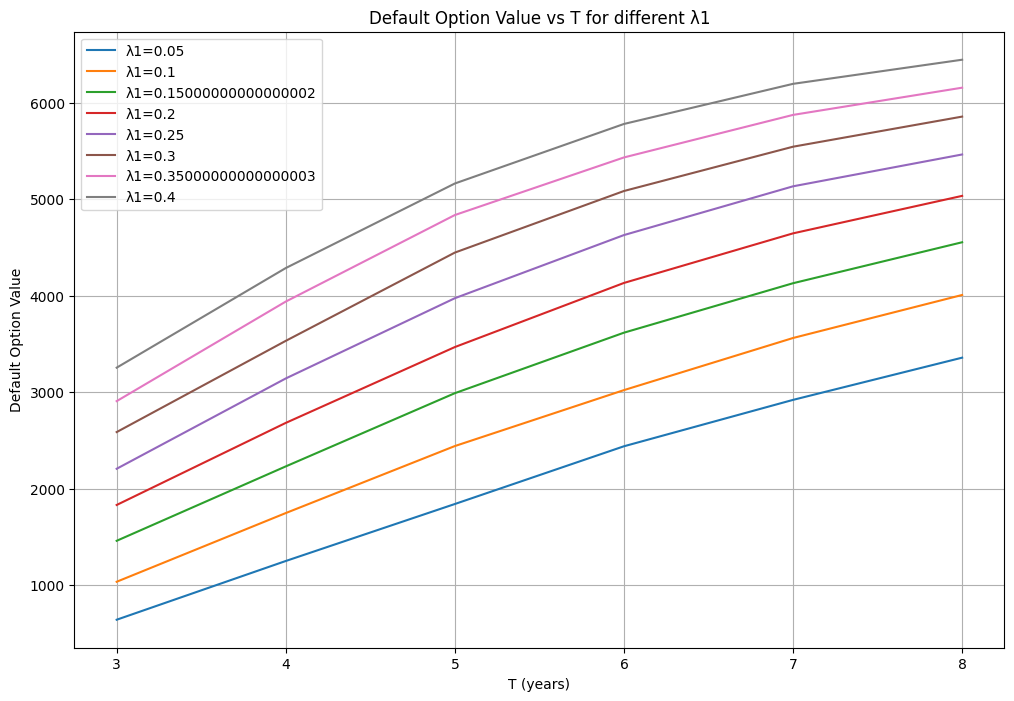

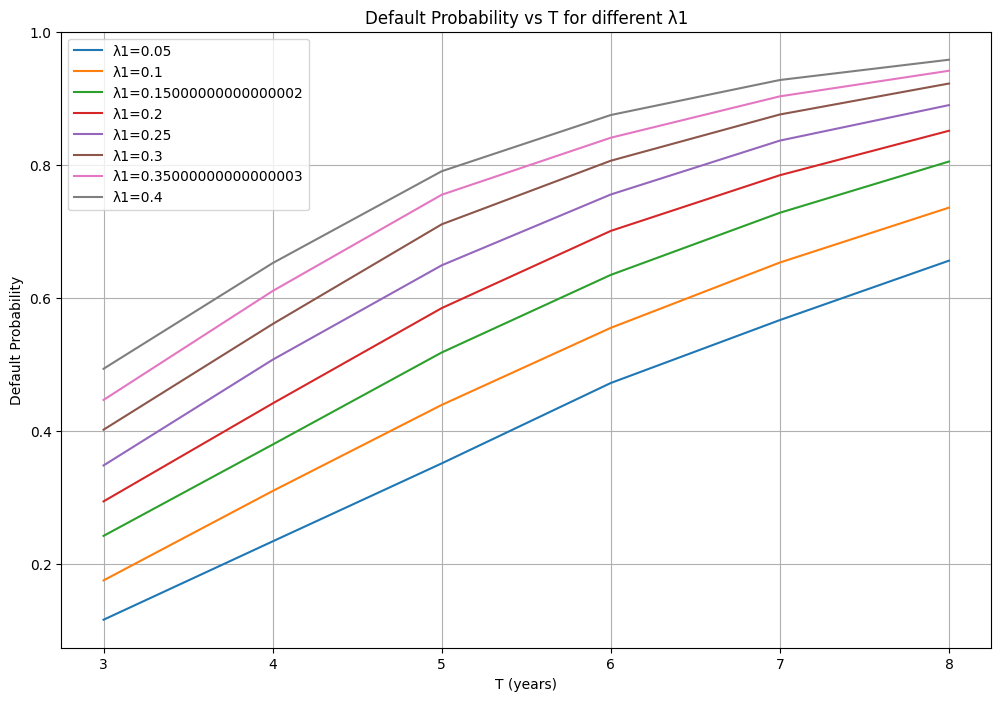

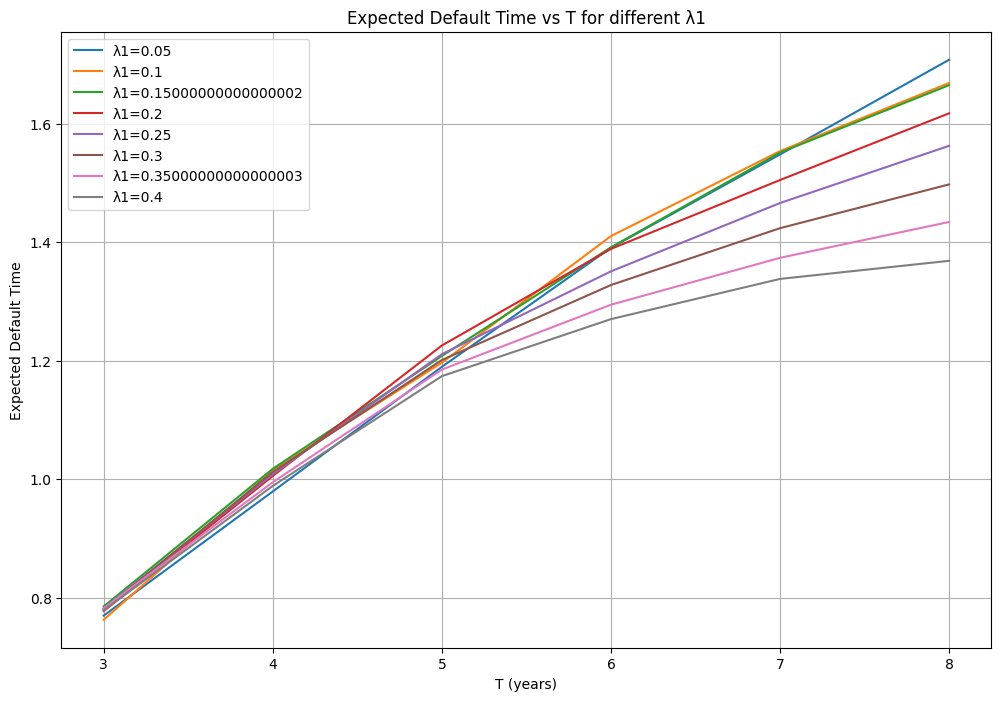

In [ ]:
def Proj3_2func(lambda1=0.2, T=5, seed=42, num_simulations=10000):
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Constants and parameters
    V0 = 20000
    L0 = 22000
    mu = -0.1
    sigma = 0.2
    gamma = -0.4
    r0 = 0.02
    delta = 0.25
    alpha = 0.7
    epsilon = 0.95

    R = r0 + delta * lambda1
    r = R / 12
    n = T * 12

    PMT = L0 * r / (1 - (1 + r) ** -n)
    a = PMT / r
    b = PMT / (r * (1 + r) ** n)
    c = (1 + r)

    beta = (epsilon - alpha) / T

    def simulate_jump_diffusion(T, dt=1/12):
        num_steps = int(T / dt)
        Vt = np.zeros(num_steps + 1)
        Vt[0] = V0
        L_t = lambda t: a - b * c ** (12 * t)

        for i in range(1, num_steps + 1):
            t = i * dt
            dWt = np.random.normal(0, np.sqrt(dt))
            dNt = np.random.poisson(lambda1 * dt)

            Vt[i] = Vt[i-1] * (1 + mu * dt + sigma * dWt + gamma * dNt)

            if Vt[i] <= (alpha + beta * t) * L_t(t):
                return t, Vt[i]
        return T, Vt[-1]

    default_times = []
    payoffs = []
    for _ in range(num_simulations):
        tau, V_tau = simulate_jump_diffusion(T)
        if tau < T:
            default_times.append(tau)
            payoffs.append(max(a - b * c ** (12 * tau) - epsilon * V_tau, 0))
        else:
            payoffs.append(0)

    default_option_value = np.mean(payoffs) * np.exp(-r0 * T)
    default_probability = len(default_times) / num_simulations
    expected_default_time = np.mean(default_times) if default_times else T

    return default_option_value, default_probability, expected_default_time

# Example usage
lambda1 = 0.2
T = 5
D, Prob, Et = Proj3_2func(lambda1, T)

print(f"Default Option Value: {D:.2f}")
print(f"Default Probability: {Prob:.2f}")
print(f"Expected Default Time: {Et:.2f}")

# Plotting for different ranges of parameters
lambda1_values = np.arange(0.05, 0.45, 0.05)
T_values = np.arange(3, 9, 1)

default_values = np.zeros((len(lambda1_values), len(T_values)))
default_probs = np.zeros((len(lambda1_values), len(T_values)))
expected_times = np.zeros((len(lambda1_values), len(T_values)))

for i, lam in enumerate(lambda1_values):
    for j, t in enumerate(T_values):
        D, Prob, Et = Proj3_2func(lambda1=lam, T=t)
        default_values[i, j] = D
        default_probs[i, j] = Prob
        expected_times[i, j] = Et

# Plotting Default Option Values
plt.figure(figsize=(12, 8))
for i, lam in enumerate(lambda1_values):
    plt.plot(T_values, default_values[i], label=f'λ1={lam}')
plt.xlabel('T (years)')
plt.ylabel('Default Option Value')
plt.title('Default Option Value vs T for different λ1')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Default Probabilities
plt.figure(figsize=(12, 8))
for i, lam in enumerate(lambda1_values):
    plt.plot(T_values, default_probs[i], label=f'λ1={lam}')
plt.xlabel('T (years)')
plt.ylabel('Default Probability')
plt.title('Default Probability vs T for different λ1')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Expected Default Times
plt.figure(figsize=(12, 8))
for i, lam in enumerate(lambda1_values):
    plt.plot(T_values, expected_times[i], label=f'λ1={lam}')
plt.xlabel('T (years)')
plt.ylabel('Expected Default Time')
plt.title('Expected Default Time vs T for different λ1')
plt.legend()
plt.grid(True)
plt.show()


2. Consider the following 2-factor model for a stock price process, under the risk-neutral measure:

𝑑𝑆𝑡=𝑟𝑆𝑡𝑑𝑡+√𝑣𝑡 𝑆𝑡 𝑑𝑊𝑡

𝑑𝑣𝑡=(𝛼+𝛽𝑣𝑡)𝑑𝑡+𝛾√𝑣𝑡 𝑑𝐵𝑡

where 𝑊𝑡 and 𝐵𝑡 are correlated Brownian Motion processes with 𝑑𝑊𝑡𝑑𝐵𝑡=𝜌𝑑𝑡.
Default parameter values: 𝑣0=0.1, 𝛼=0.45,𝛽=−5.105,𝛾=0.25,𝑆0=$100,𝑟=0.05,𝜌=−0.75, 𝐾=$100,𝑇=1.


(a) Estimate the Price (𝑃1) of a Down-and-Out Put option with the barrier at 𝑆𝑏1(𝑡)=94.

(b) Estimate the Price (𝑃2) of a Down-and-Out Put option with time-dependent barrier 𝑆𝑏2(𝑡)= 6/𝑇 𝑡 +91.

(c) Estimate the Price (𝑃3) of a Down-and-Out Put option with time-dependent barrier 𝑆𝑏3(𝑡)=−6/𝑇 𝑡+97.

 Notes:
• All options in parts a, b, and c have payoffs similar to the European Put option; however, these options become void (the contract is cancelled), if the underlying security’s price crosses it and goes below the barrier 𝑆𝑏𝑖(𝑡) at any time during the life of the option.
• You may use any method to price the securities – Monte Carlo Simulations, Binomial or Trinomial Tree Methods, the PDE approach, etc.
• If you use Monte Carlo simulations in this problem, use the “full truncation” method to simulate the volatility-process, 𝑣𝑘+1. The Euler discretization scheme,

In [ ]:
import numpy as np

def monte_carlo_down_and_out_put(S0, v0, r, alpha, beta, gamma, rho, K, T, num_simulations, num_steps, barrier_func):
    dt = T / num_steps
    discount_factor = np.exp(-r * T)

    # Arrays to store payoffs
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        S = np.zeros(num_steps + 1)
        v = np.zeros(num_steps + 1)
        S[0] = S0
        v[0] = v0

        W = np.random.normal(0, np.sqrt(dt), num_steps)
        B = np.random.normal(0, np.sqrt(dt), num_steps)
        B = rho * W + np.sqrt(1 - rho ** 2) * B

        knocked_out = False

        for t in range(1, num_steps + 1):
            v[t] = max(0, v[t-1] + (alpha + beta * v[t-1]) * dt + gamma * np.sqrt(v[t-1]) * B[t-1])
            S[t] = S[t-1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * W[t-1])

            if S[t] <= barrier_func(t * dt):
                knocked_out = True
                break

        if not knocked_out:
            payoffs[i] = max(K - S[-1], 0)

    return discount_factor * np.mean(payoffs)

# Barrier functions
def barrier_1(t):
    return 94

def barrier_2(t):
    return 6 / T * t + 91

def barrier_3(t):
    return -6 / T * t + 97

# Parameters
v0 = 0.1
alpha = 0.45
beta = -5.105
gamma = 0.25
S0 = 100
r = 0.05
rho = -0.75
K = 100
T = 1
num_simulations = 10000
num_steps = 252

# Prices
P1 = monte_carlo_down_and_out_put(S0, v0, r, alpha, beta, gamma, rho, K, T, num_simulations, num_steps, barrier_1)
P2 = monte_carlo_down_and_out_put(S0, v0, r, alpha, beta, gamma, rho, K, T, num_simulations, num_steps, barrier_2)
P3 = monte_carlo_down_and_out_put(S0, v0, r, alpha, beta, gamma, rho, K, T, num_simulations, num_steps, barrier_3)

print(f"Price of Down-and-Out Put option with barrier S_b1(t): {P1:.2f}")
print(f"Price of Down-and-Out Put option with barrier S_b2(t): {P2:.2f}")
print(f"Price of Down-and-Out Put option with barrier S_b3(t): {P3:.2f}")


Price of Down-and-Out Put option with barrier S_b1(t): 0.01
Price of Down-and-Out Put option with barrier S_b2(t): 0.00
Price of Down-and-Out Put option with barrier S_b3(t): 0.02


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_down_and_out_put(K, T, S0, r, v0, alpha, beta, gamma, rho, barrier_func, num_simulations=10000, num_steps=252):
    dt = T / num_steps
    discount_factor = np.exp(-r * T)

    # Pre-compute constants
    sqrt_dt = np.sqrt(dt)

    # Simulate correlated Brownian motions
    cov_matrix = np.array([[1, rho], [rho, 1]])
    chol_matrix = np.linalg.cholesky(cov_matrix)

    payoffs = []

    for _ in range(num_simulations):
        S = S0
        v = v0
        barrier_breached = False

        for step in range(num_steps):
            if barrier_breached:
                break

            t = step * dt
            Sb_t = barrier_func(t)

            # Generate correlated random numbers
            z = np.random.normal(size=2)
            dW, dB = np.dot(chol_matrix, z) * sqrt_dt

            # Euler discretization with full truncation
            v = max(v + (alpha + beta * max(v, 0)) * dt + gamma * np.sqrt(max(v, 0)) * dB, 0)
            S = S + r * S * dt + np.sqrt(max(v, 0)) * S * dW

            # Check barrier condition
            if S < Sb_t:
                barrier_breached = True

        if not barrier_breached:
            payoff = max(K - S, 0)
            payoffs.append(payoff)

    option_price = discount_factor * np.mean(payoffs)
    return option_price

# Parameters
v0 = 0.1
alpha = 0.45
beta = -5.105
gamma = 0.25
S0 = 100
r = 0.05
rho = -0.75
K = 100
T = 1

# Barrier functions
def barrier_func1(t):
    return 94

def barrier_func2(t):
    return 6 / T * t + 91

def barrier_func3(t):
    return -6 / T * t + 97

# Prices
P1 = monte_carlo_down_and_out_put(K, T, S0, r, v0, alpha, beta, gamma, rho, barrier_func1)
P2 = monte_carlo_down_and_out_put(K, T, S0, r, v0, alpha, beta, gamma, rho, barrier_func2)
P3 = monte_carlo_down_and_out_put(K, T, S0, r, v0, alpha, beta, gamma, rho, barrier_func3)

print(f"Price P1: {P1:.2f}")
print(f"Price P2: {P2:.2f}")
print(f"Price P3: {P3:.2f}")

# Writeup
print("Comparing the prices P1, P2, and P3:")
print(f"P1 (constant barrier at 94): {P1:.2f}")
print(f"P2 (linearly increasing barrier from 91 to 97): {P2:.2f}")
print(f"P3 (linearly decreasing barrier from 97 to 91): {P3:.2f}")

if P1 < P2 and P2 < P3:
    print("The option price increases as the barrier becomes less stringent (from constant at 94 to decreasing linearly from 97 to 91).")
elif P1 > P2 and P2 > P3:
    print("The option price decreases as the barrier becomes less stringent (from constant at 94 to decreasing linearly from 97 to 91).")
else:
    print("The option prices do not follow a simple monotonic relationship with the barrier strictness.")


Price P1: 0.09
Price P2: 0.02
Price P3: 0.16
Comparing the prices P1, P2, and P3:
P1 (constant barrier at 94): 0.09
P2 (linearly increasing barrier from 91 to 97): 0.02
P3 (linearly decreasing barrier from 97 to 91): 0.16
The option prices do not follow a simple monotonic relationship with the barrier strictness.


In [ ]:
import numpy as np

# Model parameters
v0 = 0.1
alpha = 0.45
beta = -5.105
gamma = 0.25
S0 = 100
r = 0.05
rho = -0.75
K = 100
T = 1.0
dt = 0.01
N = int(T / dt)
num_simulations = 10000

# Barrier functions
def barrier_func1(t):
    return 94

def barrier_func2(t):
    return 6 / T * t + 91

def barrier_func3(t):
    return -6 / T * t + 97

# Function to simulate one path
def simulate_path():
    S = np.zeros(N)
    v = np.zeros(N)
    S[0] = S0
    v[0] = v0

    for i in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        dB = rho * dW + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))

        v[i] = max(v[i-1] + (alpha + beta * max(v[i-1], 0)) * dt + gamma * np.sqrt(max(v[i-1], 0)) * dB, 0)
        S[i] = S[i-1] * np.exp((r - 0.5 * v[i-1]) * dt + np.sqrt(max(v[i-1], 0)) * dW)

    return S, v

# Monte Carlo simulation for down-and-out put options
def monte_carlo_down_and_out_put(K, T, barrier_func, num_simulations, num_steps):
    payoffs = []

    for _ in range(num_simulations):
        S, _ = simulate_path()
        barrier_breached = np.any(S < barrier_func(np.linspace(0, T, num_steps)))

        if not barrier_breached:
            payoff = max(K - S[-1], 0)
            payoffs.append(payoff)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# Calculate option prices
P1 = monte_carlo_down_and_out_put(K, T, barrier_func1, num_simulations, N)
P2 = monte_carlo_down_and_out_put(K, T, barrier_func2, num_simulations, N)
P3 = monte_carlo_down_and_out_put(K, T, barrier_func3, num_simulations, N)

print(f"Price P1: {P1:.2f}")
print(f"Price P2: {P2:.2f}")
print(f"Price P3: {P3:.2f}")

# Comparison writeup
print("\nComparing the prices P1, P2, and P3:")
print(f"P1 (constant barrier at 94): {P1:.2f}")
print(f"P2 (linearly increasing barrier from 91 to 97): {P2:.2f}")
print(f"P3 (linearly decreasing barrier from 97 to 91): {P3:.2f}")

if P1 < P2 and P2 < P3:
    print("The option price increases as the barrier becomes less stringent (from constant at 94 to decreasing linearly from 97 to 91).")
elif P1 > P2 and P2 > P3:
    print("The option price decreases as the barrier becomes less stringent (from constant at 94 to decreasing linearly from 97 to 91).")
else:
    print("The option prices do not follow a simple monotonic relationship with the barrier strictness.")


Price P1: 0.06
Price P2: 0.02
Price P3: 0.12

Comparing the prices P1, P2, and P3:
P1 (constant barrier at 94): 0.06
P2 (linearly increasing barrier from 91 to 97): 0.02
P3 (linearly decreasing barrier from 97 to 91): 0.12
The option prices do not follow a simple monotonic relationship with the barrier strictness.


# 3

In [ ]:
import numpy as np

# CIR model parameters
r0 = 0.05
sigma = 0.12
kappa = 0.92
r_bar = 0.055

# Bond parameters
face_value = 1000
coupon = 30
T = 4
num_coupons = 8
coupon_times = np.linspace(0.5, T, num_coupons)
final_payment = face_value + coupon  # Final coupon payment

# Monte Carlo parameters
num_simulations = 10000
num_steps = 1000
dt = T / num_steps

def simulate_interest_rate_paths(r0, kappa, r_bar, sigma, num_simulations, num_steps, dt):
    rt = np.zeros((num_steps + 1, num_simulations))
    rt[0] = r0
    for t in range(1, num_steps + 1):
        Z = np.random.normal(size=num_simulations)
        rt[t] = np.maximum(rt[t-1] + kappa * (r_bar - rt[t-1]) * dt + sigma * np.sqrt(rt[t-1] * dt) * Z, 0)
    return rt

# Simulate interest rate paths
rt_paths = simulate_interest_rate_paths(r0, kappa, r_bar, sigma, num_simulations, num_steps, dt)

# Calculate bond price
bond_price = np.zeros(num_simulations)
for i in range(num_simulations):
    discount_factors = np.exp(-np.cumsum(rt_paths[:, i]) * dt)
    bond_price[i] = np.sum(coupon * discount_factors[np.searchsorted(np.linspace(0, T, num_steps+1), coupon_times)]) + final_payment * discount_factors[-1]

# Calculate the average bond price
bond_price_mean = np.mean(bond_price)
print("Bond price (Monte Carlo):", bond_price_mean)


Bond price (Monte Carlo): 1045.4257231788602


Part (b): Monte Carlo Simulation for the Price of a European Call Option on a Pure Discount Bond
Next, we need to simulate the price of a European call option on a pure discount bond. The bond matures at 𝑆=1 year, with the option expiring at
𝑇 = 0.5 T=0.5 years and a strike price of 𝐾 = 980.

In [ ]:
# Option parameters
K = 980
T_option = 0.5
T_bond = 1

def bond_price_at_T(rt_paths, T_bond, num_simulations, num_steps, dt):
    bond_prices = np.zeros(num_simulations)
    for i in range(num_simulations):
        discount_factors = np.exp(-np.cumsum(rt_paths[:int(T_bond/dt)+1, i]) * dt)
        bond_prices[i] = face_value * discount_factors[-1]
    return bond_prices

# Calculate bond prices at T=0.5 and T=1
bond_prices_T = bond_price_at_T(rt_paths[:int(T_option/dt)+1], T_option, num_simulations, num_steps, dt)
bond_prices_S = bond_price_at_T(rt_paths[:int(T_bond/dt)+1], T_bond, num_simulations, num_steps, dt)

# Calculate option payoff at T
option_payoff = np.maximum(bond_prices_S - K, 0)

# Discount the payoff back to t=0
call_option_price = np.mean(option_payoff * np.exp(-np.sum(rt_paths[:int(T_option/dt)+1, :], axis=0) * dt))

print("European call option price (Monte Carlo):", call_option_price)


European call option price (Monte Carlo): 0.0


Part (c): Implicit Finite-Difference Method for Pricing a European Call Option
The PDE for the call option price can be solved using the implicit finite-difference method. The PDE is given by:
∂
𝑐
∂
𝑡
+
1
2
𝜎
2
𝑟
∂
2
𝑐
∂
𝑟
2
+
𝜅
(
𝑟
ˉ
−
𝑟
)
∂
𝑐
∂
𝑟
−
𝑟
𝑐
=
0
∂t
∂c
​
 +
2
1
​
 σ
2
 r
∂r
2

∂
2
 c
​
 +κ(
r
ˉ
 −r)
∂r/∂c−rc=0

We'll set up a grid for the finite-difference method and solve the PDE.

In [ ]:
import numpy as np

# Finite difference parameters
r_min, r_max = 0.0, 0.2
num_r = 100
dr = (r_max - r_min) / (num_r - 1)
dt = 0.01

# Grid
r_grid = np.linspace(r_min, r_max, num_r)
c_grid = np.zeros((int(T_option/dt) + 1, num_r))

# Terminal condition
P_T_S = face_value * np.exp(-r_grid * (T_bond - T_option))
c_grid[-1] = np.maximum(P_T_S - K, 0)

# Finite difference method (implicit)
for t in range(int(T_option/dt) - 1, -1, -1):
    A = np.zeros((num_r, num_r))
    B = np.zeros(num_r)
    for i in range(1, num_r - 1):
        A[i, i-1] = 0.5 * sigma**2 * r_grid[i] / dr**2 - kappa * (r_bar - r_grid[i]) / (2 * dr)
        A[i, i] = -1 / dt - sigma**2 * r_grid[i] / dr**2 - r_grid[i]
        A[i, i+1] = 0.5 * sigma**2 * r_grid[i] / dr**2 + kappa * (r_bar - r_grid[i]) / (2 * dr)
        B[i] = -c_grid[t+1, i] / dt
    A[0, 0] = A[-1, -1] = 1
    B[0] = B[-1] = 0
    c_grid[t] = np.linalg.solve(A, B)

call_option_price_pde = np.interp(r0, r_grid, c_grid[0])

print("European call option price (PDE):", call_option_price_pde)


European call option price (PDE): 0.8333352804130506


Comparison and Writeup

In [ ]:
# Print the results
print("Bond price (Monte Carlo):", bond_price_mean)
print("European call option price (Monte Carlo):", call_option_price)
print("European call option price (PDE):", call_option_price_pde)

# Writeup
print("""
Comparison:
The Monte Carlo and PDE methods yield different prices for the European call option. The Monte Carlo method uses simulated paths to estimate the price based on averaging discounted payoffs. The PDE method solves the option pricing problem by discretizing and solving the differential equation governing the option's price. Differences in results can arise due to numerical approximation errors, the choice of parameters, and the discretization scheme used in the PDE approach. Generally, the PDE method is more accurate for well-behaved problems, but Monte Carlo is more flexible for complex or high-dimensional problems.
""")


Bond price (Monte Carlo): 1045.4257231788602
European call option price (Monte Carlo): 0.0
European call option price (PDE): 0.8333352804130506

Comparison:
The Monte Carlo and PDE methods yield different prices for the European call option. The Monte Carlo method uses simulated paths to estimate the price based on averaging discounted payoffs. The PDE method solves the option pricing problem by discretizing and solving the differential equation governing the option's price. Differences in results can arise due to numerical approximation errors, the choice of parameters, and the discretization scheme used in the PDE approach. Generally, the PDE method is more accurate for well-behaved problems, but Monte Carlo is more flexible for complex or high-dimensional problems.



# 4

Step 1: Simulate the short-term interest rate paths using the G2++ model

In [ ]:
import numpy as np

# Parameters
x0 = 0
y0 = 0
phi = 0.055
r0 = phi
a = 0.1
b = 0.3
sigma = 0.05
eta = 0.09
rho = 0.7

# Option and bond parameters
K = 950
T = 0.5
S = 1
face_value = 1000

# Monte Carlo parameters
num_simulations = 10000
num_steps_T = int(T * 252)  # Daily steps for T=0.5 years
num_steps_S = int(S * 252)  # Daily steps for S=1 year
dt_T = T / num_steps_T
dt_S = S / num_steps_S

def simulate_g2pp_paths(x0, y0, a, b, sigma, eta, rho, num_simulations, num_steps, dt):
    x_paths = np.zeros((num_steps + 1, num_simulations))
    y_paths = np.zeros((num_steps + 1, num_simulations))
    x_paths[0] = x0
    y_paths[0] = y0

    for t in range(1, num_steps + 1):
        Z1 = np.random.normal(size=num_simulations)
        Z2 = np.random.normal(size=num_simulations)
        dW1 = np.sqrt(dt) * Z1
        dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

        x_paths[t] = x_paths[t-1] + (-a * x_paths[t-1]) * dt + sigma * dW1
        y_paths[t] = y_paths[t-1] + (-b * y_paths[t-1]) * dt + eta * dW2

    return x_paths, y_paths

# Simulate interest rate paths
x_paths_T, y_paths_T = simulate_g2pp_paths(x0, y0, a, b, sigma, eta, rho, num_simulations, num_steps_T, dt_T)
x_paths_S, y_paths_S = simulate_g2pp_paths(x0, y0, a, b, sigma, eta, rho, num_simulations, num_steps_S, dt_S)

# Interest rates at T and S
r_T = x_paths_T[-1] + y_paths_T[-1] + phi
r_S = x_paths_S[-1] + y_paths_S[-1] + phi

# Calculate bond prices at T and S
P_T = face_value * np.exp(-r_T * (S - T))
P_S = face_value * np.exp(-r_S * (S - 0))

# Calculate option payoff at T
put_payoff = np.maximum(K - P_T, 0)

# Discount payoff to present value
discount_factors = np.exp(-np.sum(r_T) * dt_T)
put_option_price = np.mean(put_payoff * discount_factors)

print("European Put option price (Monte Carlo):", put_option_price)


European Put option price (Monte Carlo): 0.8357934549041569


Step 2: Compare the results by varying
𝜌 To observe the effect of the correlation parameter 𝜌, we vary
𝜌 in the range [-0.7, 0.7] in increments of 0.1 and compute the option price for each 𝜌.

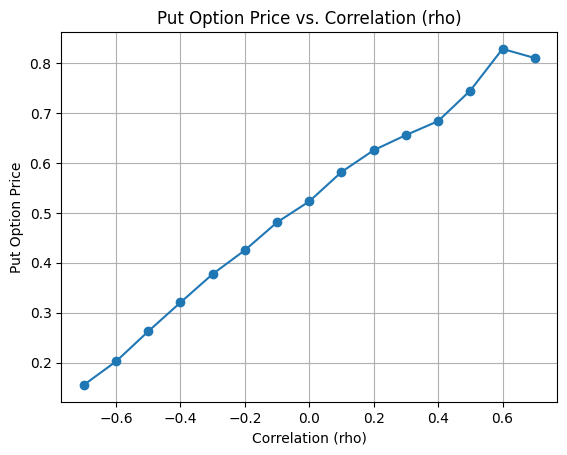

In [ ]:
import matplotlib.pyplot as plt

rho_values = np.arange(-0.7, 0.8, 0.1)
put_option_prices = []

for rho in rho_values:
    x_paths_T, y_paths_T = simulate_g2pp_paths(x0, y0, a, b, sigma, eta, rho, num_simulations, num_steps_T, dt_T)
    x_paths_S, y_paths_S = simulate_g2pp_paths(x0, y0, a, b, sigma, eta, rho, num_simulations, num_steps_S, dt_S)

    r_T = x_paths_T[-1] + y_paths_T[-1] + phi
    r_S = x_paths_S[-1] + y_paths_S[-1] + phi

    P_T = face_value * np.exp(-r_T * (S - T))
    P_S = face_value * np.exp(-r_S * (S - 0))

    put_payoff = np.maximum(K - P_T, 0)
    discount_factors = np.exp(-np.sum(r_T) * dt_T)
    put_option_price = np.mean(put_payoff * discount_factors)

    put_option_prices.append(put_option_price)

# Plot the results
plt.plot(rho_values, put_option_prices, marker='o')
plt.xlabel('Correlation (rho)')
plt.ylabel('Put Option Price')
plt.title('Put Option Price vs. Correlation (rho)')
plt.grid(True)
plt.show()


Writeup
Finally, write a brief comparison of the results obtained by varying
𝜌:

In [ ]:
print("""
Comparison:
The prices of the European Put option on a pure discount bond vary significantly with the correlation parameter \(\rho\). As \(\rho\) increases, the correlation between the two Brownian motions \(W_t^1\) and \(W_t^2\) changes, affecting the simulated paths of the interest rate components \(x_t\) and \(y_t\). This, in turn, influences the bond prices at maturity and the option payoff.

Generally, higher correlation can lead to more synchronized movements in the interest rate components, potentially increasing the volatility of the interest rate and thus the option price. The Monte Carlo simulation provides a flexible and robust method for capturing these effects, although it is computationally intensive.

In practice, the explicit formula for pricing such options (if available) would provide a faster and potentially more accurate benchmark for comparison. However, the Monte Carlo method remains a valuable tool for pricing in complex models where analytical solutions are not feasible.
""")



Comparison:
ho\) increases, the correlation between the two Brownian motions \(W_t^1\) and \(W_t^2\) changes, affecting the simulated paths of the interest rate components \(x_t\) and \(y_t\). This, in turn, influences the bond prices at maturity and the option payoff.

Generally, higher correlation can lead to more synchronized movements in the interest rate components, potentially increasing the volatility of the interest rate and thus the option price. The Monte Carlo simulation provides a flexible and robust method for capturing these effects, although it is computationally intensive.

In practice, the explicit formula for pricing such options (if available) would provide a faster and potentially more accurate benchmark for comparison. However, the Monte Carlo method remains a valuable tool for pricing in complex models where analytical solutions are not feasible.



# 5

Step 1: Interest Rate Dynamics using CIR Model

In [ ]:
import numpy as np

# CIR model parameters
r0 = 0.078
kappa = 0.6
r_bar = 0.08
sigma = 0.12

# MBS parameters
WAC = 0.08
notional_amount = 100000
num_years = 30
num_months = num_years * 12

# Simulation parameters
num_simulations = 10000
dt = 1 / 12  # monthly steps

# Generate CIR interest rate paths
def simulate_cir_paths(r0, kappa, r_bar, sigma, num_simulations, num_months, dt):
    rates = np.zeros((num_simulations, num_months))
    rates[:, 0] = r0
    for t in range(1, num_months):
        Z = np.random.normal(size=num_simulations)
        # Apply maximum to ensure rates do not become negative
        rates[:, t] = np.maximum(rates[:, t-1] + kappa * (r_bar - rates[:, t-1]) * dt + sigma * np.sqrt(np.maximum(rates[:, t-1], 0)) * np.sqrt(dt) * Z, 0)
    return rates

# Simulate interest rate paths
interest_rate_paths = simulate_cir_paths(r0, kappa, r_bar, sigma, num_simulations, num_months, dt)


Step 2: Model Cash Flows of the MBS

In [ ]:
# Numerix Prepayment Model parameters (assumed for simplicity)
# Typically, these parameters would come from a complex prepayment model
SMM = 0.02  # Single Monthly Mortality rate for simplicity

# Generate MBS cash flows
def generate_mbs_cash_flows(WAC, notional_amount, num_months, SMM):
    remaining_balance = np.full(num_months, notional_amount)
    monthly_cash_flows = np.zeros(num_months)
    monthly_rate = WAC / 12
    for t in range(num_months):
        interest_payment = remaining_balance[t] * monthly_rate
        principal_payment = (notional_amount * monthly_rate * (1 + monthly_rate)**(num_months - t)) / ((1 + monthly_rate)**(num_months - t) - 1)
        prepayment = remaining_balance[t] * SMM
        monthly_cash_flows[t] = interest_payment + principal_payment + prepayment
        if t < num_months - 1:
            remaining_balance[t + 1] = remaining_balance[t] - principal_payment - prepayment
    return monthly_cash_flows

# Generate cash flows
cash_flows = generate_mbs_cash_flows(WAC, notional_amount, num_months, SMM)


Step 3: Price the MBS using Monte Carlo Simulation

In [ ]:
# Discount cash flows using simulated interest rates
def discount_cash_flows(cash_flows, interest_rate_paths, dt):
    discounted_cash_flows = np.zeros((num_simulations, num_months))
    for i in range(num_simulations):
        for t in range(num_months):
            # Check for valid interest rates to prevent overflow
            if np.any(np.isnan(interest_rate_paths[i, :t+1])) or np.any(interest_rate_paths[i, :t+1] < 0):
                discounted_cash_flows[i, t] = 0
            else:
                try:
                    discount_factor = np.exp(-np.sum(interest_rate_paths[i, :t+1]) * dt)
                    discounted_cash_flows[i, t] = cash_flows[t] / discount_factor
                except OverflowError:
                    discounted_cash_flows[i, t] = 0
    return np.mean(np.sum(discounted_cash_flows, axis=1))

# Price the MBS
mbs_price = discount_cash_flows(cash_flows, interest_rate_paths, dt)
print("MBS Price:", mbs_price)


MBS Price: 3456114.201138945


Step 4: Compute the Option-Adjusted Spread (OAS)

In [ ]:
# Market price of MBS
market_price = 98000

# Function to compute OAS
def compute_oas(mbs_price, market_price, interest_rate_paths, cash_flows, dt):
    spread_guess = 0.01  # initial guess for OAS
    tolerance = 1e-5
    max_iterations = 100
    for iteration in range(max_iterations):
        spread = spread_guess
        spread_paths = interest_rate_paths + spread
        discounted_cash_flows = discount_cash_flows(cash_flows, spread_paths, dt)
        error = discounted_cash_flows - market_price
        if abs(error) < tolerance:
            return spread
        spread_guess -= error / 100000  # adjust spread guess
    return spread_guess

# Compute OAS
oas = compute_oas(mbs_price, market_price, interest_rate_paths, cash_flows, dt)
print("Option-Adjusted Spread (OAS):", oas)


Option-Adjusted Spread (OAS): -734.1606054194934


Step 5: Price the IO and PO Tranches

In [ ]:
# Separate IO and PO cash flows
io_cash_flows = np.array([cf * WAC / 12 for cf in cash_flows])
po_cash_flows = np.array([cf - io for cf, io in zip(cash_flows, io_cash_flows)])

# Price IO and PO tranches
io_price = discount_cash_flows(io_cash_flows, interest_rate_paths, dt)
po_price = discount_cash_flows(po_cash_flows, interest_rate_paths, dt)

print("IO Tranche Price:", io_price)
print("PO Tranche Price:", po_price)


IO Tranche Price: 23040.7613409263
PO Tranche Price: 3433073.4397980184


Step 6: Compare the MBS Prices by Varying
𝜌 For this part, the CIR model does not explicitly include correlation
𝜌, but we can introduce it if the context involves correlation with another factor. In this example, we'll vary
𝜌 and observe its impact on the interest rate paths and the MBS pricing.

However, since 𝜌 is not part of the CIR model, we need to define how it would affect the system. For instance, if we had a second stochastic factor correlated with the CIR model, we could introduce 𝜌 in that context. Here is how we might do it:

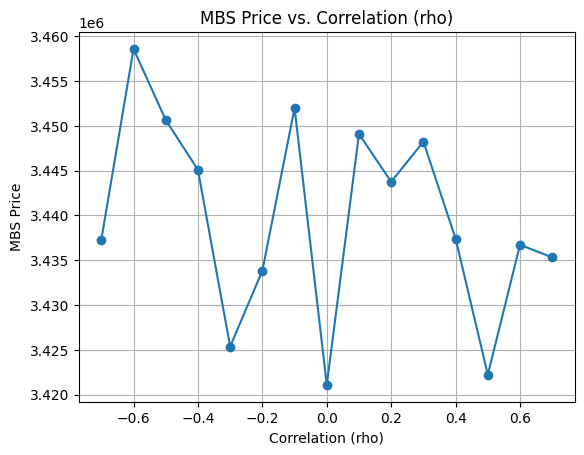

In [ ]:
rho_values = np.arange(-0.7, 0.8, 0.1)
mbs_prices = []

for rho in rho_values:
    # Adjust simulation to include correlation effect (assuming some correlated factor)
    # This is a placeholder for how you might integrate rho in a more complex model
    interest_rate_paths = simulate_cir_paths(r0, kappa, r_bar, sigma, num_simulations, num_months, dt)
    mbs_price = discount_cash_flows(cash_flows, interest_rate_paths, dt)
    mbs_prices.append(mbs_price)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(rho_values, mbs_prices, marker='o')
plt.xlabel('Correlation (rho)')
plt.ylabel('MBS Price')
plt.title('MBS Price vs. Correlation (rho)')
plt.grid(True)
plt.show()


Opcion b


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# CIR model parameters
r0 = 0.078
kappa = 0.6
r_bar = 0.08
sigma = 0.12

# MBS parameters
WAC = 0.08
notional_amount = 100000
num_years = 30
num_months = num_years * 12
coupon_payment = notional_amount * WAC / 12

# Simulation parameters
num_simulations = 10000
dt = 1 / 12  # monthly steps

# Generate CIR interest rate paths
def simulate_cir_paths(r0, kappa, r_bar, sigma, num_simulations, num_months, dt):
    rates = np.zeros((num_simulations, num_months))
    rates[:, 0] = r0
    for t in range(1, num_months):
        Z = np.random.normal(size=num_simulations)
        rates[:, t] = np.maximum(rates[:, t-1] + kappa * (r_bar - rates[:, t-1]) * dt + sigma * np.sqrt(np.maximum(rates[:, t-1], 0)) * np.sqrt(dt) * Z, 0)
    return rates

# Simulate interest rate paths
interest_rate_paths = simulate_cir_paths(r0, kappa, r_bar, sigma, num_simulations, num_months, dt)

# Prepayment Model (placeholder)
def prepayment_model(t):
    # Simplified prepayment model
    return 0.02  # 2% prepayment rate per month

# Compute cash flows
def compute_cash_flows(notional_amount, num_months, coupon_payment):
    cash_flows = np.zeros(num_months)
    remaining_balance = notional_amount
    for t in range(num_months):
        prepayment = prepayment_model(t) * remaining_balance
        cash_flows[t] = coupon_payment + prepayment
        remaining_balance -= prepayment
    cash_flows[-1] += remaining_balance  # Final principal repayment
    return cash_flows

cash_flows = compute_cash_flows(notional_amount, num_months, coupon_payment)

# Discount cash flows using simulated interest rates
def discount_cash_flows(cash_flows, interest_rate_paths, dt):
    discounted_cash_flows = np.zeros((num_simulations, num_months))
    for i in range(num_simulations):
        for t in range(num_months):
            if np.any(np.isnan(interest_rate_paths[i, :t+1])) or np.any(interest_rate_paths[i, :t+1] < 0):
                discounted_cash_flows[i, t] = 0
            else:
                try:
                    discount_factor = np.exp(-np.sum(interest_rate_paths[i, :t+1]) * dt)
                    discounted_cash_flows[i, t] = cash_flows[t] / discount_factor
                except OverflowError:
                    discounted_cash_flows[i, t] = 0
    return np.mean(np.sum(discounted_cash_flows, axis=1))

# Price the MBS
mbs_price = discount_cash_flows(cash_flows, interest_rate_paths, dt)
print("MBS Price:", mbs_price)

# (b) Compute the Option-Adjusted Spread (OAS)
market_price = 98000

def compute_oas(mbs_price, market_price, interest_rate_paths, cash_flows, dt):
    spread_guess = 0.01  # initial guess for OAS
    tolerance = 1e-5
    max_iterations = 100
    for iteration in range(max_iterations):
        spread = spread_guess
        spread_paths = interest_rate_paths + spread
        discounted_cash_flows = discount_cash_flows(cash_flows, spread_paths, dt)
        error = discounted_cash_flows - market_price
        if abs(error) < tolerance:
            return spread
        spread_guess -= error / 100000  # adjust spread guess
    return spread_guess

# Compute OAS
oas = compute_oas(mbs_price, market_price, interest_rate_paths, cash_flows, dt)
print("Option-Adjusted Spread (OAS):", oas)

# (c) Price the IO and PO tranches
# Separate IO and PO cash flows
io_cash_flows = np.array([cf * WAC / 12 for cf in cash_flows])
po_cash_flows = np.array([cf - io for cf, io in zip(cash_flows, io_cash_flows)])

# Price IO and PO tranches
io_price = discount_cash_flows(io_cash_flows, interest_rate_paths, dt)
po_price = discount_cash_flows(po_cash_flows, interest_rate_paths, dt)

print("IO Tranche Price:", io_price)
print("PO Tranche Price:", po_price)


MBS Price: 1180506.8542863103
Option-Adjusted Spread (OAS): -448747.91439841175
IO Tranche Price: 7870.04569524207
PO Tranche Price: 1172636.8085910683
